In [1]:
import numpy as np
import pandas
import scanpy as sc
import anndata
import json
import matplotlib.pyplot as plt
import scvelo as scv
import os

%matplotlib inline

/home/picrin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dimensionality reduction and stemness analysis 

We've already pre-processed our data, and are ready to begin analysis. One of the first challenges is the very high dimensionality of our dataset. It's difficult to search for patterns when we can't easily "see" or "interact" with our data, and high dimensionality is a hindrance, with potentially thousands of plots that would have to be anlaysed and reasoned about. A common technique to solve this problem is dimensionality reduction, which can be either linear (preserve angles and distances in the original space, carrying out minimally lossy projection onto the reduced 2d or 3d space; e.g. PCA) or non-linear ("roughly" preserving angles and distances at least in a "global" sense, but with more adventurous characterics locally; e.g tSNE or UMAP).

In [2]:
data_path = os.path.join("data", "01_bile_duct_cancer.h5ad")

In [3]:
adata = anndata.read_h5ad(data_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 1937 × 1784 
    obs: 'n_counts', 'percent_mito', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'before_filter_nonvariable_genes', 'before_filter_rare_genes'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# Principal component analysis (PCA)

First, we're going to reduce the dimensionality of the data by running principal component analysis (PCA). PCA is one of the least advanced dimensionality reduction techniques, which can be a virtue, as one can easily develop strong geometric intuition about the behaviour of the algorithm, making it much easier to reason about and troubleshoot any issues. Developing geometric intuition about non-linear techniques is not impossible, especially if one is willing to perform a range of simulations looking at [various kinds of simulated datasets, testing different types of parameters](https://distill.pub/2016/misread-tsne/).

In [5]:
sc.tl.pca(adata, svd_solver='arpack')

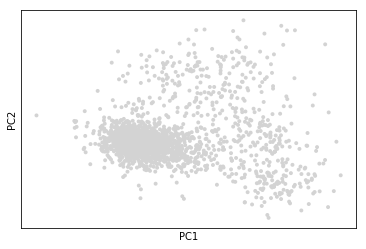

In [6]:
sc.pl.pca(adata)

As we can see there's a significant dispersion along both principal components. Some investigation demonstrates that total, pre-normalisation transcript count per cell ("n_counts", as computed in the normalisation step), is still a major factor differentiating cells.

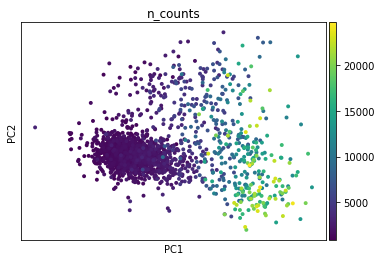

In [7]:
sc.pl.pca(adata, color='n_counts')

An easy, but inaccurate, explanation is that those cells which have more transcripts are represented by longer transcription vectors and therefore are positioned farther away from the origin of the coordinate system (as represented by a hypothetical cell with a transcription of every gene equal to zero), and therefore are represented by more extreme values along the major PCs. The reason this explanation is inaccurate is two-fold: 
1. Earlier in the analysis we normalised our cells, by rescaling total transcription count (or, mathematically speaking, rescaling all vectors to a common length with respect to the L1 metric), so we wouldn't expect (L2) vector lengths to play major role in the investigation downstream of normalisation.
2. Assuming the effect is purely due to vector length, with no bias towards any particular group of genes, we should observe a uniformly bright outer ring with a dark inside -- which clearly isn't the case. 

Unfortunately, it emerges that subsequent step of logging the data, although biologically sound, destroys the normalisation, and produces cells with L1 length highly correlated with the original, pre-normalisation length, which possibly refutes the first of the two remarks. The interplay of length normalisation, logging, and bias due to confounding is subtle, and is discussed separately in the `Appendix01_normalisation_issues.ipynb`.

# Regressing out cell size confounder

A common approach to deal with bias due to confounders is "regressing out" a confounder from the dataset. The approach works by fitting a linear model that predicts expression levels of all the genes, from a (group of) confounder(s), and derives "denoised" signal from the resulting residuals. This often seems to result in a desirable "dissipation" of the signal introduced by the confounder evenly across the dataset. We can confirm this effect on our dataset by re-computing our low-dimensional PCA embedding.

In [8]:
sc.api.pp.regress_out(adata, keys="n_counts")
sc.pp.scale(adata)

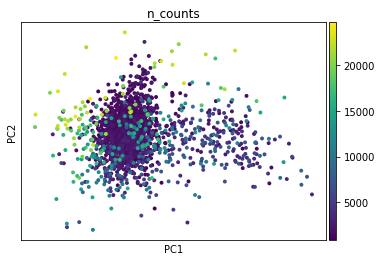

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')

# PCA captures small amount of variance in the data

Unfortunately, 2-dimensional PCA embedding captures only about 1% of the total variance. This isn't much, which highlights the need for improved dimensionality reduction techniques, and should be kept in mind when trying to interpret these plots.

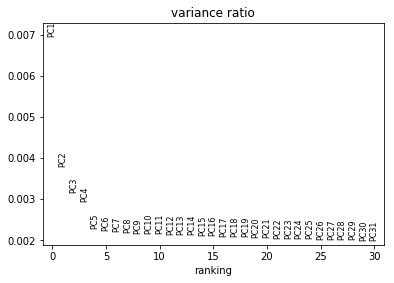

In [10]:
sc.pl.pca_variance_ratio(adata)

# Regressing out cell cycle 

Many single cell studies (including this one) focus primarily on development of a population of cells. Least developed, most immature cells are called "progenitor" cells, in contrast with "differentiated cells". One hopes that a large proportion of variation, as visualised in the PCA or tSNE/UMAP plots is due to differentiation. However, differentiation is just one of many processes, which are simulataneously co-occuring in a population of cells. Many of these processes will be outside of the interest of the study. One prominent example is cell cycle. Cells, and especially cancer cells, continuously divide, and the stage of cell division has a big effect on the cell's transcription profile. Interestingly, after cell division, daughter cells usually have a good understanding of which development stage they are supposed to be at: the level of differentation is "saved" before cell division using DNA methylation and gets "restored" after division, with the daughter cells continuing differentation along the path charted by the parent cell.

Biomarkers of the S and G2/M cell cycle stages [have been previously described](https://doi.org/10.1126/science.aad0501). We can compute a cumulative cell cycle score for each of those biomarker sets, and regress them out as an unwanted source of variation.

In [11]:
with open(os.path.join("data", "s_genes")) as f:
    cell_cycle_s_genes = set(map(str.strip, f))

In [12]:
len(cell_cycle_s_genes)

43

In [13]:
with open(os.path.join("data", "g2m_genes")) as f:
    cell_cycle_g2m_genes = set(map(str.strip, f))

In [14]:
len(cell_cycle_g2m_genes)

54

This is how we can get a list of all non-filtered genes

In [15]:
current_genes = set(adata.var.index)

Unfortunately, not all genes are still present, as some were filtered out in the normalisation stage, and some possibly contain out-of-date gene names.

In [16]:
len(cell_cycle_s_genes)

43

In [17]:
len(cell_cycle_s_genes - current_genes)

31

In [18]:
len(cell_cycle_g2m_genes)

54

In [19]:
len(cell_cycle_g2m_genes - current_genes)

18

We can check which of the genes are not present in our original, pre-filtered dataset.

In [20]:
full_genes = set(adata.uns["before_filter_rare_genes"][0])

In [21]:
cell_cycle_s_genes - full_genes

{'MLF1IP'}

In [22]:
cell_cycle_g2m_genes - full_genes

{'FAM64A', 'HN1'}

Consulting literature we can find correct names for these genes

In [23]:
cell_cycle_g2m_genes.remove("FAM64A")
cell_cycle_g2m_genes.add("PIMREG")

In [24]:
cell_cycle_g2m_genes.remove("HN1")
cell_cycle_g2m_genes.add("JPT1")

In [25]:
cell_cycle_s_genes.remove("MLF1IP")
cell_cycle_s_genes.add("CENPU")

In [26]:
cell_cycle_genes = cell_cycle_g2m_genes.union(cell_cycle_s_genes)

In [27]:
cell_cycle_genes - full_genes

set()

We can compute cell cycle scores

In [28]:
sc.tl.score_genes_cell_cycle(adata, s_genes=cell_cycle_s_genes.intersection(current_genes), g2m_genes=cell_cycle_g2m_genes.intersection(current_genes))

And plot them onto our original 2-dimensional PCA embedding

... storing 'phase' as categorical


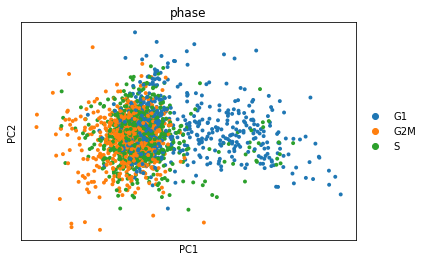

In [29]:
sc.pl.pca_scatter(adata, color='phase')

Or creating a new embedding, focusing only on the cell-cycle genes.

In [30]:
adata_cc_genes = adata[:, list(cell_cycle_genes.intersection(current_genes))]

In [31]:
# Due to a suspected bug in scanpy we have to re-initialise adata_cc_genes
adata_cc_genes = anndata.AnnData(X=adata_cc_genes.X, var=adata_cc_genes.var, obs=adata_cc_genes.obs)

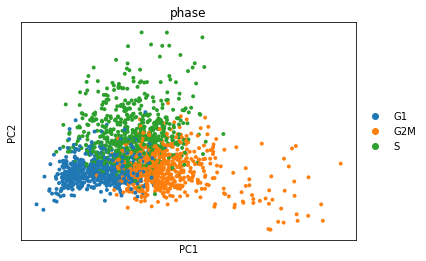

In [32]:
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

As we can see, regressing these scores out seems to remove cell cycle as a source of variation in this experiment.

In [33]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

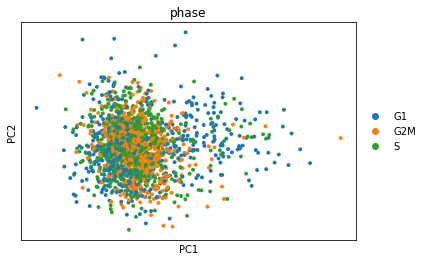

In [34]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_scatter(adata, color='phase')

Using linear regression to remove uninteresting sources of variation is not very sophisticated, more advanced techniques to decompose variation into different sources of biologically interesting signal exist and can give potentially improved results, for example using gaussian process latent variable modeling, such as with a popular single cell analysis tool [sclvm](https://github.com/PMBio/scLVM).

# Initial stemness analysis

Cancer stem cells play an important role in the development of cancer, cancer relapse, and are potentially an important target in cancer treatment. Prior work shows that expression of certain genes can [indicate stemness](https://doi.org/10.4103/ctm.ctm_69_16). Studying differential expression of these genes is a good starting point when trying to identify cancer stem cells. We focus specifically on liver cancer stemness biomarkers.

In [35]:
liver_cancer_stemness = ["PTPRC", "CD24", "PROM1", "ANPEP", "THY1", "SOX2", "NANOG", "SALL4"]

Unfortunately only one of these genes, CD24 survived the gene filtering stage.

In [36]:
for gene in liver_cancer_stemness:
    print(gene, gene in full_genes, gene in current_genes)

PTPRC True False
CD24 True True
PROM1 True False
ANPEP True False
THY1 True False
SOX2 True False
NANOG True False
SALL4 True False


Interestingly, the marker seems to be unevenly distributed in our data, with cancer stemness being one plausible explanation.

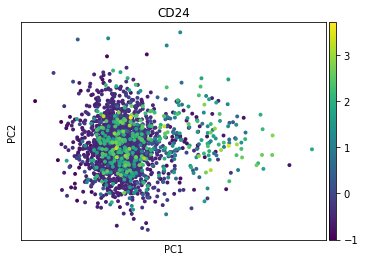

In [37]:
sc.pl.pca(adata, color='CD24')

We need to perform further analysis to understand more an apparent differential distribution of this marker.

# Further stemness analysis

The first step for many downstream algorithms (e.g. louvain clustering or UMAP) is to compute a neighbourhood graph. We have to decide how many neighbours, and what embedding we're going to compute the neighbourhood in. By default, scanpy provides us with 50 PCs from the PCA analysis. Trying to capture as much variation as possible, we'll take those 50 PCs. For the number of neighbours we will take a small fraction of the total number of cells, e.g. 40.

In [38]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=50)

## Embedding the neighborhood graph

Scanpy suggests embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)). The advantage given is potentially more faithful global connectivity of the manifold than tSNE, which should result in better preservation of cell trajectories. It also computes faster than tSNE.

In [39]:
sc.tl.umap(adata)

As we can see, UMAP manages to more clearly capture the "stemness" region, but both cell cycle and transcript size still seem to be significant confounders. This is an area for future work.

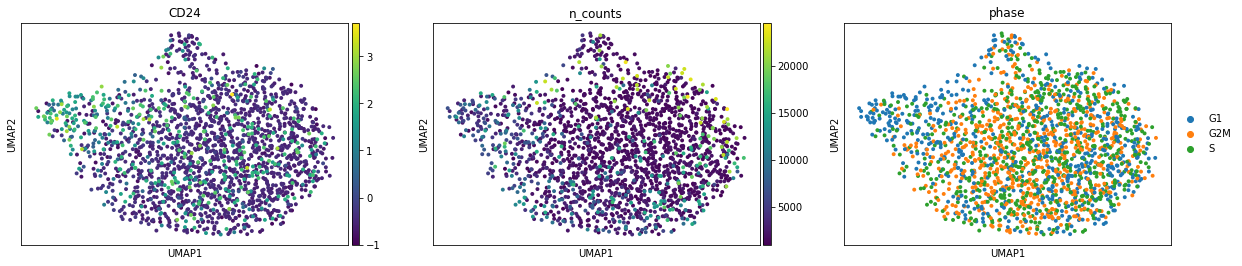

In [40]:
sc.pl.umap(adata, color=["CD24", "n_counts", "phase"])

## Clustering the neighbourhood graph

As Seurat and many others, scanpy recommends the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [41]:
sc.tl.louvain(adata)

We can plot all detected clusters, alongside our stemness biomarker.

saving figure to file ./figures/umapposter_1.png


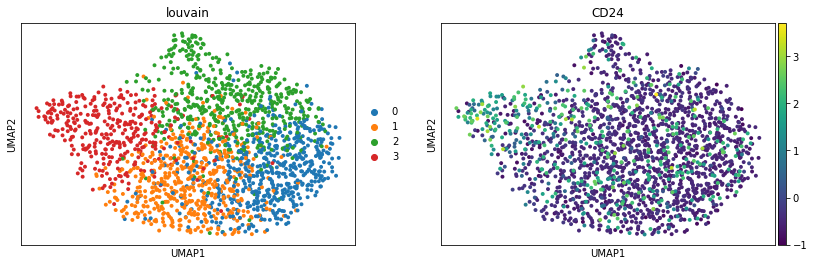

In [55]:
sc.pl.umap(adata, color=['louvain', 'CD24'], save="poster_1.png")

We can run differential expression analysis on each cluster vs all other clusters. This allows to establish the most characteristic set of genes for each cluster. We use the wilcoxon test, which can be more robust in case of long-tailed or irregularly shaped distributions than e.g. a t-test.

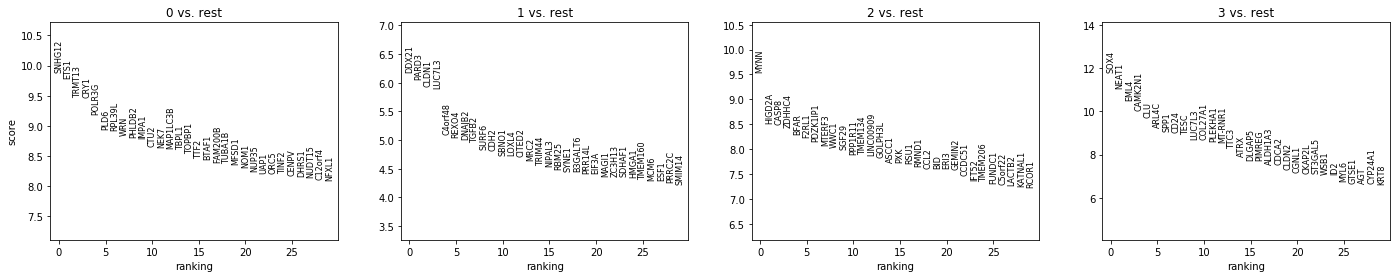

In [43]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', corr_method="benjamini-hochberg")
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

As we can see, the first gene coming up in the cluster corresponding to hypothetical stemness is SOX4, which is known to play a role in embryonic development and can indicate stem-like cell program. This, combined with high expression of CD24 further strengthens our belief that the cells in this cluster are stemmy.

Although generally difficult to interpret, a list of (Benjamini-Hochberg corrected) p-values can be extracted for any given cluster, using the following snippet

In [44]:
cluster_no = 2
n = 10
pvals_adj = np.array(adata.uns['rank_genes_groups']['pvals_adj'].tolist()).T[cluster_no][:n].tolist()
names = np.array(adata.uns['rank_genes_groups']['names'].tolist()).T[cluster_no][:n].tolist()
list(zip(names, pvals_adj))

[('MYNN', 1.2909927703971693e-18),
 ('HIGD2A', 8.615813981245297e-15),
 ('CASP8', 8.615813981245297e-15),
 ('ZDHHC4', 1.1729736192811489e-14),
 ('BFAR', 3.13079939296875e-14),
 ('F2RL1', 4.539274069188347e-14),
 ('PDZK1IP1', 7.714987275033435e-14),
 ('MTERF3', 1.2557798989227386e-13),
 ('WWC1', 1.731633494922774e-13),
 ('SGF29', 1.9361001906678398e-13)]

# Computing velocity

A final piece of investigation is so-called "RNA velocity". It's a novel technique, recently developed at [Harvard Medical School and Karolinska Institutet](https://doi.org/10.1038/s41586-018-0414-6). Through simulatenously studying unspliced and spliced transcript counts, it can be used to compute a gradient of change of the transcript with respect to time. This is our final piece of evidence, which, at least with regards to our embedding, seems to show that previously discussed cluster of cells indeed is the source of change in our data.

In [45]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00.25) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00.15) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00.50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [48]:
scv.pl.velocity_embedding_grid

<function scvelo.plotting.velocity_embedding_grid.velocity_embedding_grid>

In [51]:
scv.tl.velocity_embedding(adata, basis='umap')
scv.pl.velocity_embedding_grid(adata, basis='umap', arrow_length=4, arrow_size=1.5, save="poster_2.png", dpi=1000)
#plt.savefig("poster_2.png", format="png", dpi=1000)

computing velocity embedding
    finished (0:00:00.34) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/velocity_umap_poster_2.png


<Figure size 432x288 with 0 Axes>

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Summary

We've built a pipeline, which can detect cancer stem cells using three different techniques:
1. Detecting pre-determined stemness biomarkers and visualising them in a low-dimensional embedding.
2. Community detection in a neighbourhood graph computed in a high-dimensional embedding, followed by differential expression of cluster-specific genes.
3. RNA velocity, and identification of the "source" of velocity flow.